## Dataset

In [ ]:
!wget "http://www.vision.ee.ethz.ch/ntire18/o-haze/O-HAZE.zip"

In [ ]:
!unzip "/content/O-HAZE.zip"

In [1]:
import os 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm 
import glob
import torch.nn as nn
import torch
from tqdm.auto import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def make_tile(image_path, path_to_save, patch_size=32):
  
  img = Image.open(image_path)
  image_name = image_path.split("/")[-1].split(".")[0]

  if not os.path.exists(os.path.join(path_to_save, image_name)):
    os.mkdir(os.path.join(path_to_save, image_name))

  tiles = 0
  
  for w in range(0, img.size[0], patch_size):
    
    for h in range(0, img.size[1], patch_size):
      
      w_end = w + patch_size
      h_end = h + patch_size

      cropped = np.array(img)[h: h_end, w: w_end]

      if cropped.shape != (patch_size, patch_size, 3):
        continue
      
      path_to_save_image = os.path.join(path_to_save, image_name, "{}_tiles_{}.jpg".format(image_name, tiles))
      Image.fromarray(cropped).save(path_to_save_image)

      tiles += 1


In [4]:
# for image_path in tqdm(glob.glob("/content/# O-HAZY NTIRE 2018/GT/*")[0:2]):
#   make_tile(image_path, "/content/drive/MyDrive/hazy_dataset/GT")

In [14]:
# !rm -r "/content/drive/MyDrive/hazy_dataset/GT"

In [5]:
# for image_path in tqdm(glob.glob("/content/# O-HAZY NTIRE 2018/hazy/40_outdoor*")):
#   make_tile(image_path, "/content/drive/MyDrive/hazy_dataset/hazy")

In [6]:
len(glob.glob("/content/drive/MyDrive/hazy_dataset/hazy/40_outdoor_hazy/*"))

11445

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
gen_lr = 2e-5
disc_lr = 4e-5
batch_size=32
device

'cuda:0'

## DataLoader

In [3]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5)),
])

In [5]:
class patch_dataset(Dataset):

  def __init__(self, dataset_root, transforms=None):
    
    self.transforms = transforms

    GT_path = os.path.join(dataset_root, "GT")
    hazy_path = os.path.join(dataset_root, "hazy")

    self.pairs = []

    for folder in os.listdir(GT_path):

      for image_name in os.listdir(os.path.join(GT_path, folder)):
        
        hazy_image_name = image_name.split(".")[0].split("_")
        hazy_image_name[2] = "hazy"
        hazy_image_name = "_".join(hazy_image_name)
        hazy_image_name = hazy_image_name + ".jpg"

        folder_hazy = folder.split("_")
        folder_hazy[2] = "hazy"
        folder_hazy = "_".join(folder_hazy)
        

        hazy = os.path.join(hazy_path, folder_hazy, hazy_image_name)
        gt = os.path.join(GT_path, folder, image_name)

        self.pairs.append((hazy, gt))
      

  def __getitem__(self, index):
    
    haze_path, gt_path = self.pairs[index]

    hazed_image = Image.open(haze_path)

    gt_image = Image.open(gt_path)
    
    if self.transforms != None :
      hazed_image = self.transforms(hazed_image)
      gt_image = self.transforms(gt_image)

    
    return (hazed_image, gt_image)
    
  
  def __len__(self):
    return len(self.pairs)

In [6]:
dataset = patch_dataset("/content/drive/MyDrive/hazy_dataset/", transform)

In [7]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [8]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Generator and Discriminator

In [9]:
# gen = nn.Sequential(
#     nn.ConvTranspose2d(3, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 128, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(128, 64, 3),
#     nn.ReLU(),

#     nn.ConvTranspose2d(64, 32, 3),
#     nn.ReLU(),

#     nn.Conv2d(32, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),


#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

#     nn.Conv2d(3, 3, 3),
#     nn.ReLU(),

# )

gen = nn.Sequential(
    nn.Conv2d(3, 128, 3, padding="same"),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 128, 3, padding="same"),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.Conv2d(128, 64, 3, padding="same"),
    nn.BatchNorm2d(64),
    nn.ReLU(),

    nn.Conv2d(64, 3, 3, padding="same"),
    nn.Tanh(),
)

In [10]:
x = torch.randn(1, 3, 32, 32)
gen(x).shape

torch.Size([1, 3, 32, 32])

In [11]:
disc = nn.Sequential(
    nn.Conv2d(3, 16, 3),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.18),

    nn.Conv2d(16, 32, 5),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.18),

    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.18),

    nn.Flatten(),

    nn.Linear(64 * 24 * 24, 1)
)

In [12]:
x = torch.randn(10, 3, 32, 32)
disc(x).shape

torch.Size([10, 1])

## Loss

In [13]:
criterion = nn.BCEWithLogitsLoss()
disc_optim = torch.optim.Adam(disc.parameters(), lr=disc_lr)
gen_optim = torch.optim.Adam(gen.parameters(), lr=gen_lr)

In [14]:
def gen_loss(gen, disc, hazed_images, device):

  gen_out = gen(hazed_images)
  disc_out = disc(gen_out)

  loss = criterion(disc_out, torch.ones_like(disc_out))

  return loss

In [15]:
def disc_loss(gen, disc, hazed_images, gt_images, device):

  gen_out_fake = gen(hazed_images).detach()
  disc_out_fake = disc(gen_out_fake)
  fake_loss = criterion(disc_out_fake, torch.zeros_like(disc_out_fake))

  disc_out_real = disc(gt_images)
  real_loss = criterion(disc_out_real, torch.ones_like(disc_out_real))

  loss = 1/2 * (fake_loss + real_loss)

  return loss

## Training

In [17]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_tensor_images(image_tensor, num_images=25, size=(3, 32, 32)):
  
  image_tensor = (image_tensor + 1) / 2 # between 0 and 1 
  image_tensor = image_tensor.cpu().detach()

  image_grid = make_grid(image_tensor[:num_images], nrow=5)
  plt.imshow(image_grid.permute(1, 2, 0).squeeze())
  plt.show()


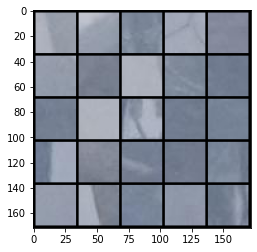

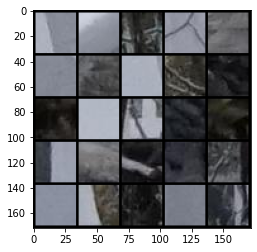

In [52]:
X, y = next(iter(train_loader))
show_tensor_images(X)
show_tensor_images(y)

  0%|          | 0/358 [00:00<?, ?it/s]

generator loss :  0.7716
discriminator loss :  0.73728


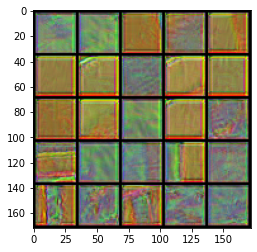

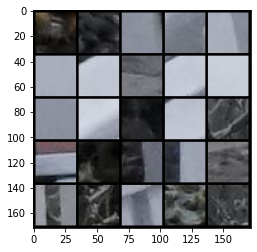

generator loss :  0.77337
discriminator loss :  0.65156


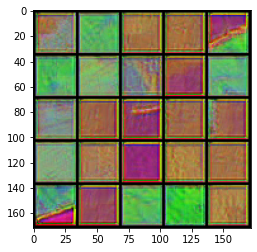

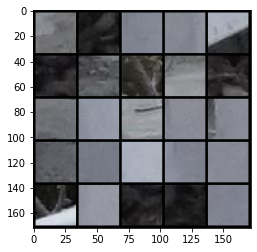

generator loss :  0.94783
discriminator loss :  0.59803


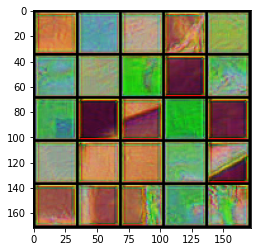

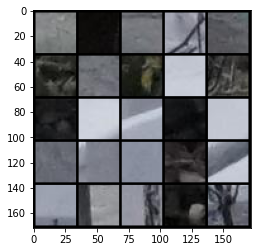

generator loss :  0.9446
discriminator loss :  0.64309


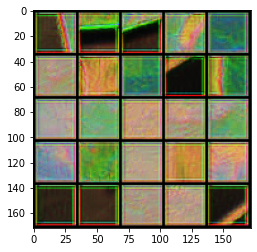

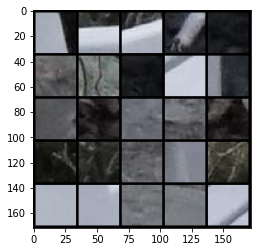

generator loss :  0.90481
discriminator loss :  0.58197


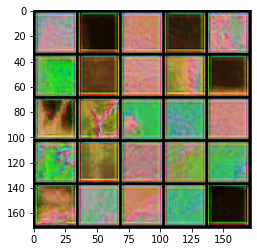

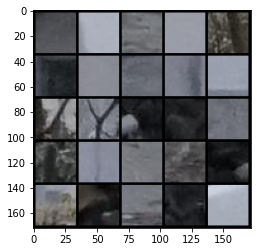

In [ ]:
cur_step = 0

for epoch in range(5):
  
  for iteration, (X, y) in enumerate(tqdm(train_loader)):

    ## training generator
    gen_optim.zero_grad()
    g_loss = gen_loss(gen, disc, X, device)
    g_loss.backward()
    gen_optim.step()


    ## training discriminator

    disc_optim.zero_grad()
    d_loss = disc_loss(gen, disc, X, y, device)
    d_loss.backward()
    disc_optim.step()



    if iteration % 20 == 0:
      print("generator loss : ", np.round(g_loss.item(), 5))
      print("discriminator loss : ", np.round(d_loss.item(), 5))

      with torch.no_grad():
        
        X, y = next(iter(train_loader))
        gen_out_test = gen(X)
        show_tensor_images(gen_out_test)
        show_tensor_images(y)


    cur_step += 1 

